In [2]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

train_data = pd.read_csv('happiness_data_train.csv')
test_data = pd.read_csv('happiness_data_test.csv')

num_rows = train_data.shape[0]
print(num_rows)


1559


A.
There are 1559 rows in the train data meaning there is 1559 samples of the data subracting the column headers.
There are no categorical attributes because all features have a numerical value; therefore, all 9 are continuous valued features


B.

       Life Ladder  Log GDP per capita  Social support  \
count  1559.000000         1533.000000     1549.000000   
mean      5.469321            9.362995        0.812689   
std       1.113280            1.160240        0.118762   
min       2.375000            6.635000        0.290000   
25%       4.649500            8.460000        0.753000   
50%       5.374000            9.456000        0.835000   
75%       6.272500           10.332000        0.905000   
max       8.019000           11.648000        0.987000   

       Healthy life expectancy at birth  Freedom to make life choices  \
count                       1522.000000                   1537.000000   
mean                          63.331680                      0.741882   
std                            7.478307                      0.142326   
min                           32.300000                      0.260000   
25%                           58.340000                      0.646000   
50%                           65.180000

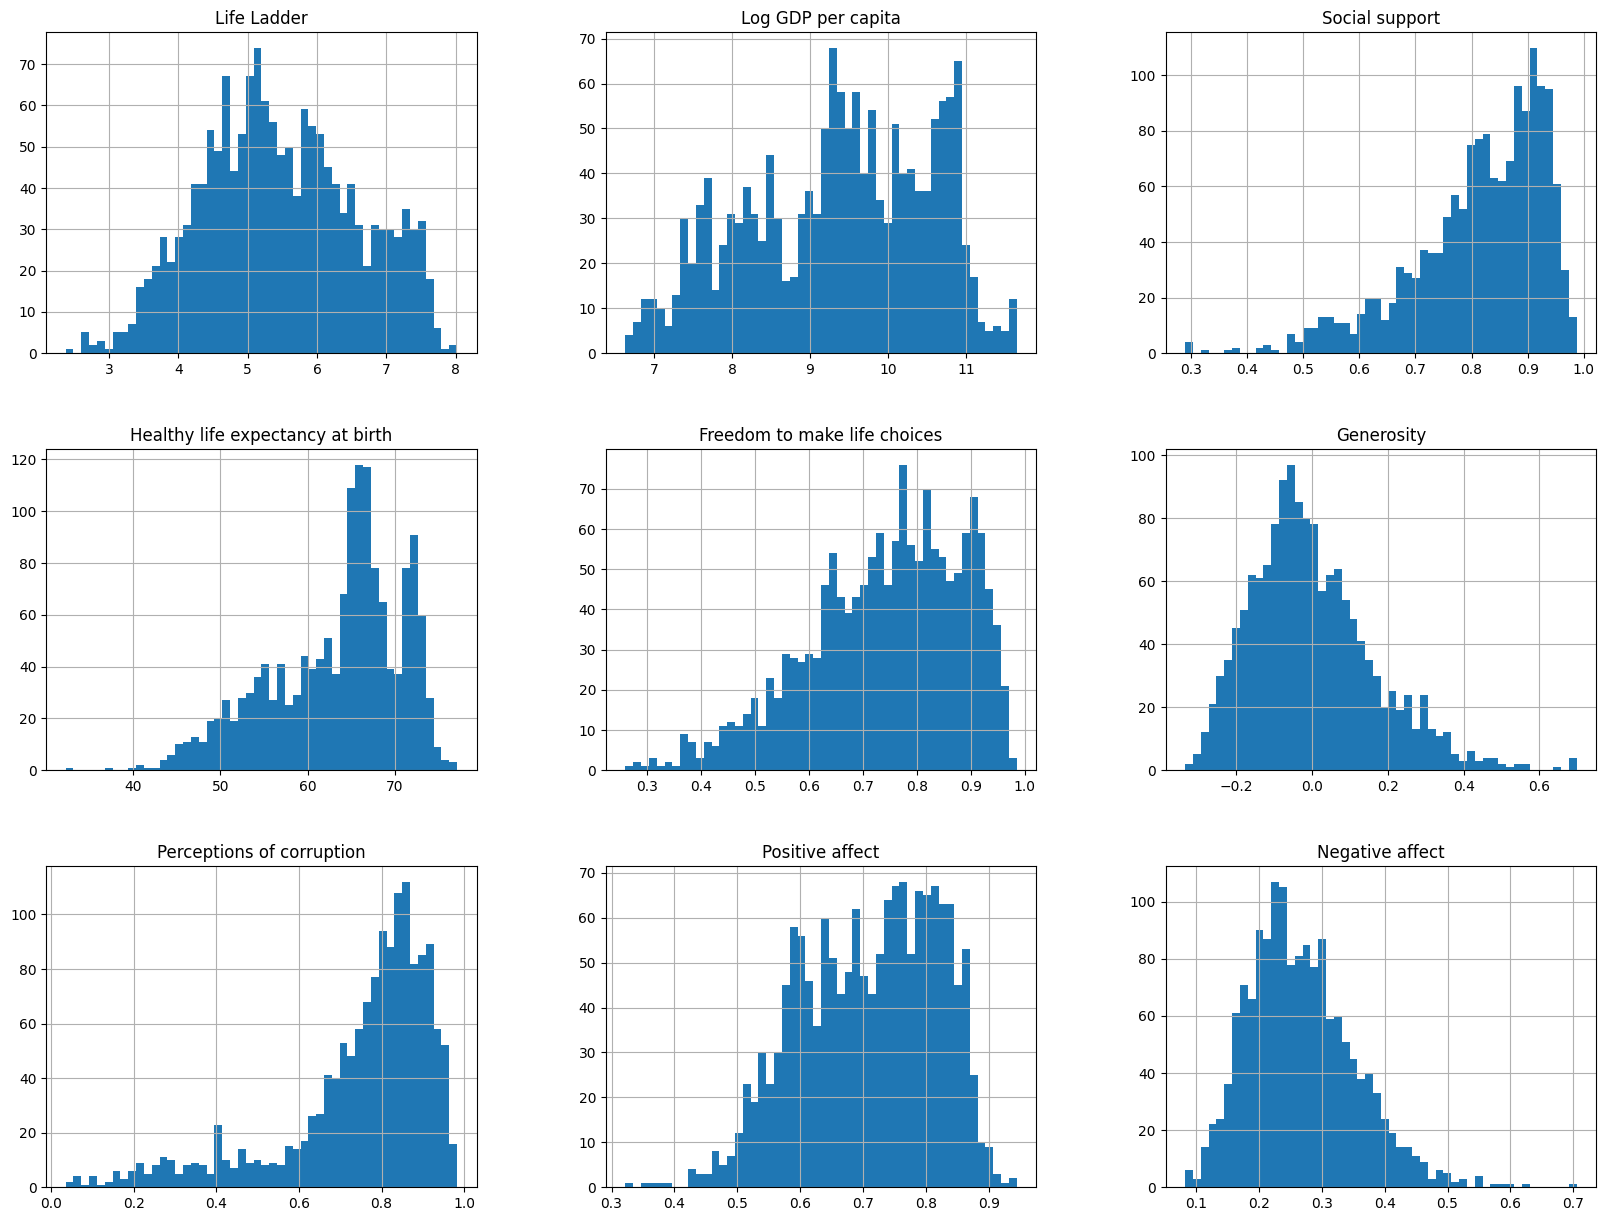

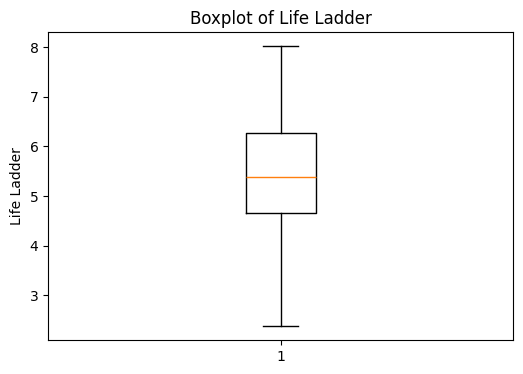

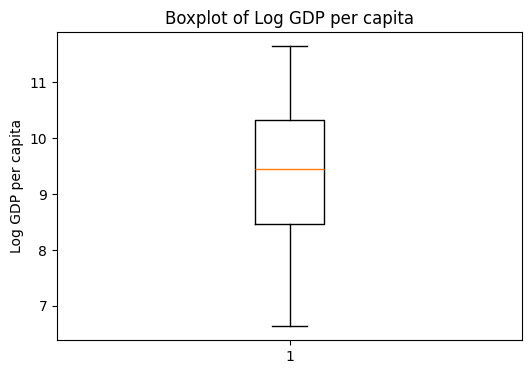

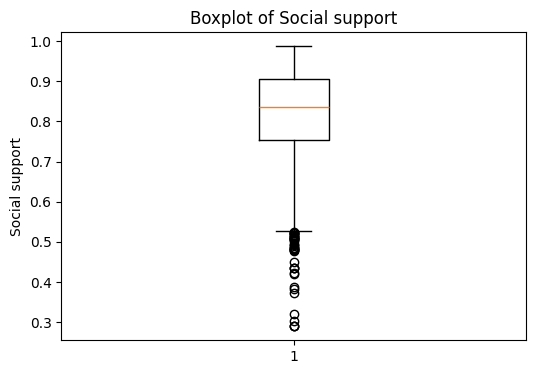

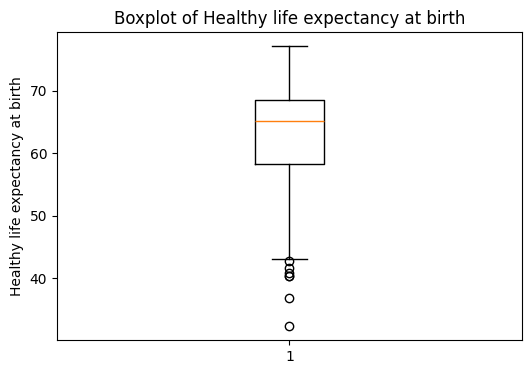

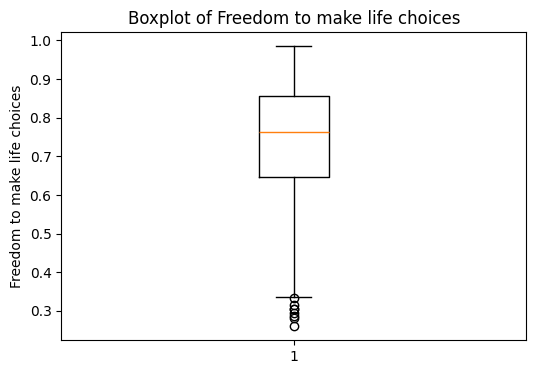

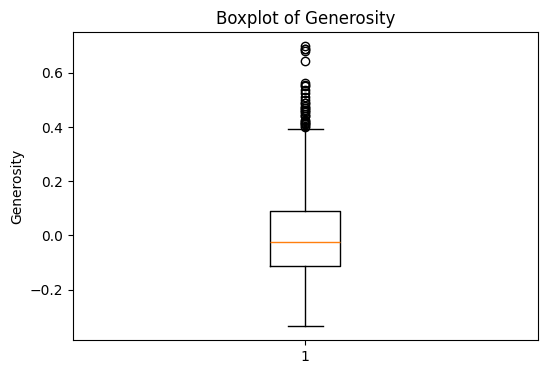

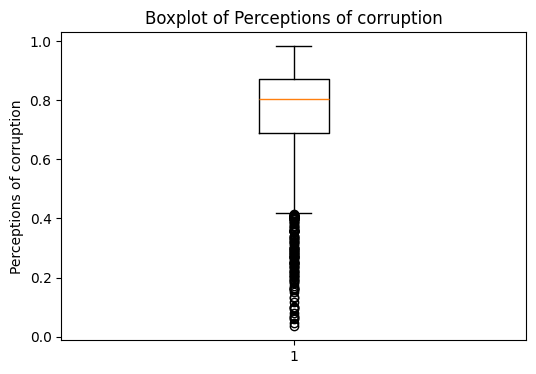

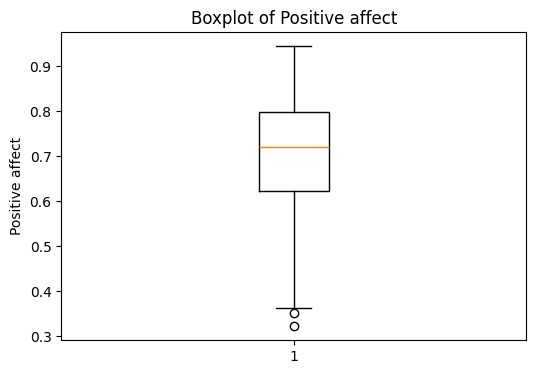

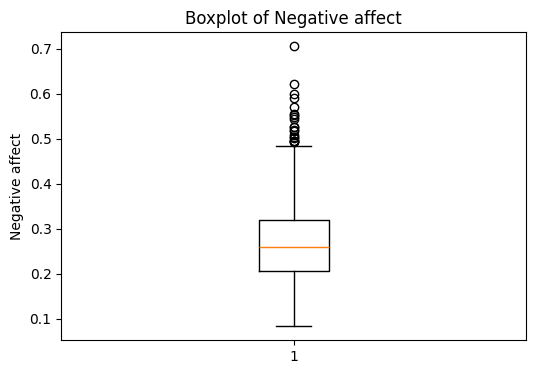

In [3]:
print(train_data.describe())
train_data.hist(bins = 50, figsize = (20,15))

for feature in ['Life Ladder', 'Log GDP per capita', 'Social support',
            'Healthy life expectancy at birth', 'Freedom to make life choices',
            'Generosity', 'Perceptions of corruption',
            'Positive affect', 'Negative affect']:

    plt.figure(figsize=(6,4))   # new figure each time
    plt.boxplot(train_data[feature].dropna())  # dropna to avoid issues with missing values
    plt.title(f"Boxplot of {feature}")
    plt.ylabel(feature)
    plt.show()

plt.show()


Life Ladder: Life ladder is the most consistent of all the attributes likely because it is the result of the other features. It holds no outliers and the mean is 5.4 near the center of the scale 1-10 and the standard deviation is 1.1 meaning that the data is almost perfectly evenly distributed

Log GDP per capita: also holds no outliers, consistent attribute but holds a few missing values

Social Support: There are many outliers within this data set. There are not that many missing samples which is good. And most of social support is in the > .8 range.

Healthy life expectancy at birth: There are outliers on the lower end of the life expectancy with no outliers on the top and has the 3rd highest amount of sample data missing

Freedom to make life choices: 4th highest amount of missing samples, but has outliers on the mottom range near 0.3

Generosity: Has half of the sample in the negative range unlile the previous attributes. Has outliers near the top of generousity showing that is is average on the lower side. Second highest amount of samples missing

Perception of corruption: Highest amount of missing samples and by far the most amount of outliers from the 0.4 to 0 range. 75% of data is within the 0.7 and above range

Positive affect: has a very low number of outliers with a good standard deviation of the data

Negative affect: has many outliers in the above .5 to .7 range. Most data is 0.5 and lower

for missing values there is the possibility of needing to drop these samples or fill them with the median, average, or mode to fit the data set better

for the outliers we can add a ceiling or floor to these data sets to reduce the amount of outliers. We could also remove these outliers if through some insights these samples seem inconsisntent or too broad of an outlier. We could also just keep these outliers if they are known to be significant to detecting the happiness score. Possibility of just rare outliers that are meaningful


C.

                                  Life Ladder  Log GDP per capita  \
Life Ladder                          1.000000            0.786712   
Log GDP per capita                   0.786712            1.000000   
Social support                       0.703878            0.696893   
Healthy life expectancy at birth     0.750773            0.850872   
Freedom to make life choices         0.529819            0.359674   
Generosity                           0.194970           -0.006162   
Perceptions of corruption           -0.427562           -0.341493   
Positive affect                      0.534640            0.296017   
Negative affect                     -0.301821           -0.215581   

                                  Social support  \
Life Ladder                             0.703878   
Log GDP per capita                      0.696893   
Social support                          1.000000   
Healthy life expectancy at birth        0.621460   
Freedom to make life choices            0.420372 

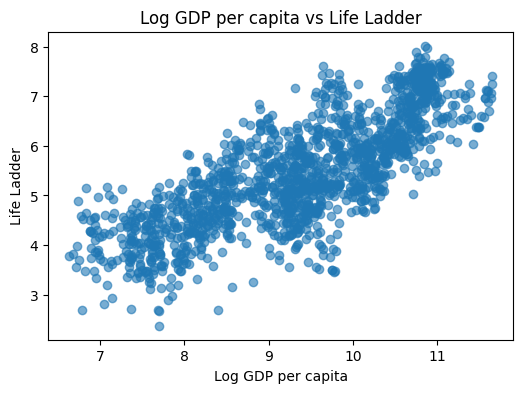

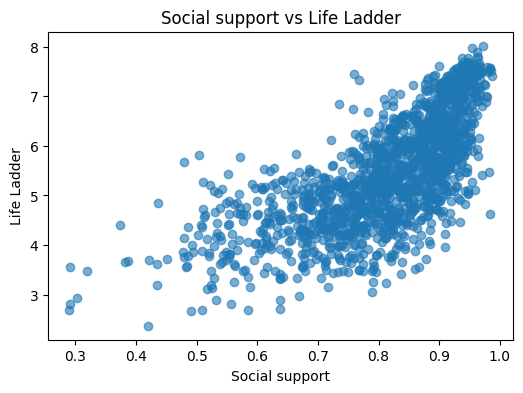

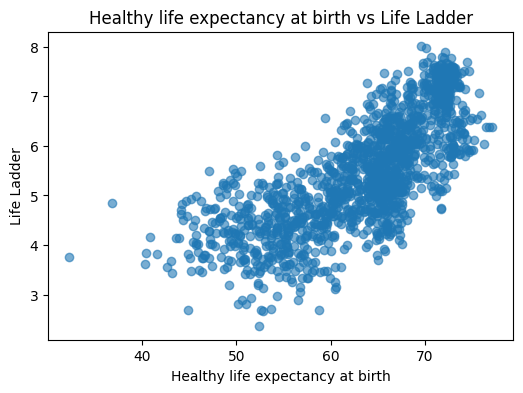

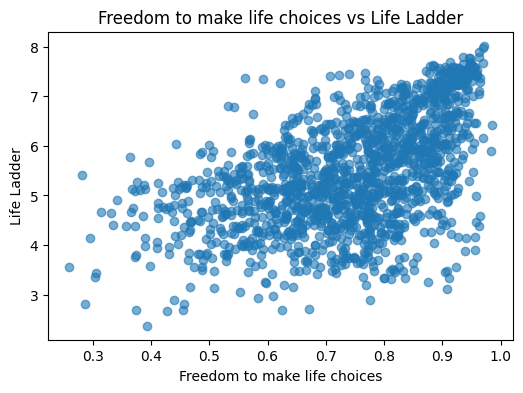

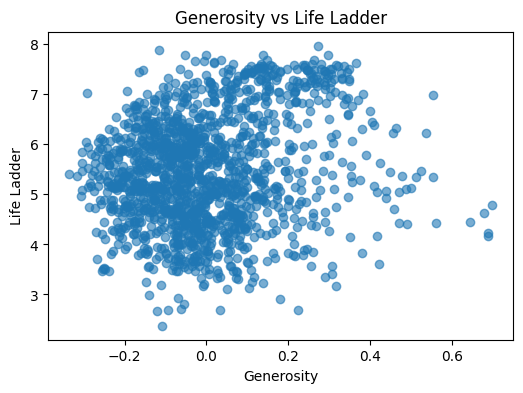

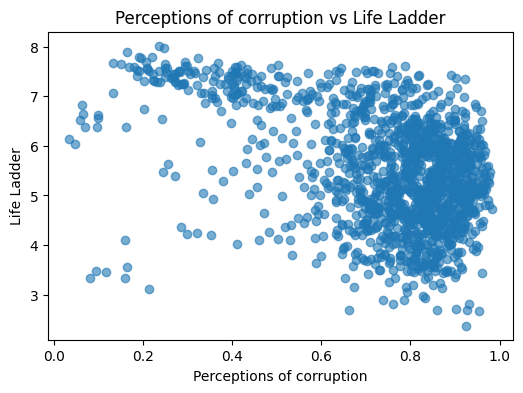

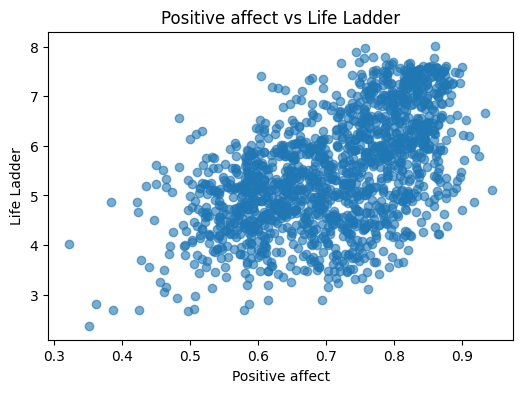

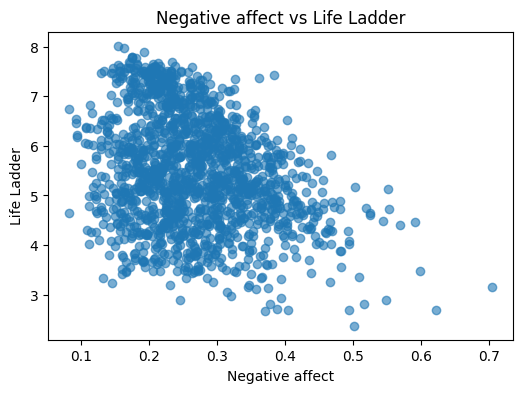

In [4]:
corr_matrix = train_data.corr(method="pearson")
print(corr_matrix)

label = "Life Ladder"

for col in train_data.columns:
    if col != label:
        plt.figure(figsize=(6,4))
        plt.scatter(train_data[col], train_data[label], alpha=0.6)
        plt.xlabel(col)
        plt.ylabel(label)
        plt.title(f"{col} vs {label}")
        plt.show()

D.

In [5]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
import math
from sklearn.metrics import root_mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split

X = train_data.drop(columns=["Life Ladder"])
y = train_data["Life Ladder"]

preprocessor = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),  # tried mean, median, most_frequent, mean is lowest rmse
    ("scaler", StandardScaler())
])

four_fold_cross_validation = KFold(n_splits=4, shuffle=True, random_state=42)

rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

# Closed form solution Single Value Decomposition
linreg_pipeline = Pipeline([
    ("prep", preprocessor),
    ("linreg", LinearRegression())
])

scores = cross_val_score(linreg_pipeline, X, y, cv=four_fold_cross_validation, scoring=rmse_scorer)
print("Closed-form LinearRegression (SVD) Cross Validation RMSE:", -scores.mean())

# Scale for SGDRegression, not needed in closed form
sgd_pipeline = Pipeline([
    ("prep", preprocessor),
    ("sgd", SGDRegressor(penalty=None, max_iter=1000, tol=1e-3, random_state=42))
])

scores = cross_val_score(sgd_pipeline, X, y, cv=four_fold_cross_validation, scoring=rmse_scorer)
print("SGDRegressor Cross Validation RMSE:", -scores.mean())

alphas = [0.001, 0.01, 0.1]
penalties = ["l2", "l1", "elasticnet"]  # l2 = Ridge, l1 = Lasso
learning_rates = ['constant', 'optimal', 'invscaling', 'adaptive']
etas = [0.001, 0.01, 0.1]

results = {}

for penalty in penalties:
    for alpha in alphas:
        for lr in learning_rates:
            for eta in etas:
                pipe = Pipeline([
                    ("prep", preprocessor),
                    ("sgd", SGDRegressor(
                        penalty=penalty,
                        alpha=alpha,
                        learning_rate=lr,
                        eta0=eta,
                        max_iter=1000,
                        tol=1e-3,
                        l1_ratio=0.5,  # only matters for elasticnet
                        random_state=42
                    ))
                ])
                scores = cross_val_score(
                    pipe, X, y, cv=four_fold_cross_validation, scoring=rmse_scorer
                )
                avg_rmse = -scores.mean()
                results[(penalty, alpha, lr, eta)] = avg_rmse
                print(f"{penalty.upper()} alpha={alpha} lr={lr} eta={eta} CV RMSE: {avg_rmse:.4f}")

# best-performing combo
best_combo = min(results, key=results.get)
print("\nBest combo:")
print(f"Penalty={best_combo[0]}, Alpha={best_combo[1]}, LearningRate={best_combo[2]}, Eta0={best_combo[3]}")
print(f"Best RMSE: {results[best_combo]:.4f}")




Closed-form LinearRegression (SVD) Cross Validation RMSE: 0.5481916979152677
SGDRegressor Cross Validation RMSE: 0.5480460840221566
L2 alpha=0.001 lr=constant eta=0.001 CV RMSE: 0.5485
L2 alpha=0.001 lr=constant eta=0.01 CV RMSE: 0.5507
L2 alpha=0.001 lr=constant eta=0.1 CV RMSE: 1.2656
L2 alpha=0.001 lr=optimal eta=0.001 CV RMSE: 0.5892
L2 alpha=0.001 lr=optimal eta=0.01 CV RMSE: 0.5892
L2 alpha=0.001 lr=optimal eta=0.1 CV RMSE: 0.5892
L2 alpha=0.001 lr=invscaling eta=0.001 CV RMSE: 0.5535
L2 alpha=0.001 lr=invscaling eta=0.01 CV RMSE: 0.5480
L2 alpha=0.001 lr=invscaling eta=0.1 CV RMSE: 0.5535
L2 alpha=0.001 lr=adaptive eta=0.001 CV RMSE: 0.5482
L2 alpha=0.001 lr=adaptive eta=0.01 CV RMSE: 0.5483
L2 alpha=0.001 lr=adaptive eta=0.1 CV RMSE: 0.5483
L2 alpha=0.01 lr=constant eta=0.001 CV RMSE: 0.5485
L2 alpha=0.01 lr=constant eta=0.01 CV RMSE: 0.5506
L2 alpha=0.01 lr=constant eta=0.1 CV RMSE: 1.2571
L2 alpha=0.01 lr=optimal eta=0.001 CV RMSE: 0.5484
L2 alpha=0.01 lr=optimal eta=0.01 CV 

Train best model: penalty = Ridge(l2), alpha = 0.01, learning rate  = invscaling, eta0 = 0.01

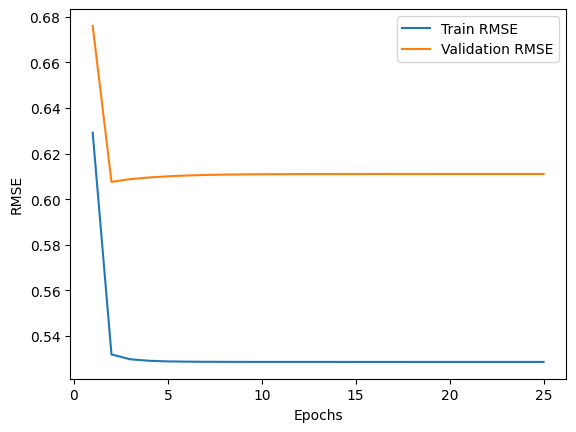

In [6]:
best_model = Pipeline([
    ("prep", preprocessor),
    ("sgd", SGDRegressor(
        penalty="l2",
        alpha=0.01,
        learning_rate= "invscaling",
        eta0=0.01,
        max_iter=1,
        warm_start=True,
        tol=None,
        random_state=42
    ))
])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


n_epochs = 25
train_rmse, val_rmse = [], []

for epoch in range(n_epochs):
    best_model.fit(X_train, y_train)
    y_train_pred = best_model.predict(X_train)
    y_val_pred = best_model.predict(X_val)

    train_rmse.append(root_mean_squared_error(y_train, y_train_pred))
    val_rmse.append(root_mean_squared_error(y_val, y_val_pred))

plt.plot(range(1, n_epochs+1), train_rmse, label="Train RMSE")
plt.plot(range(1, n_epochs+1), val_rmse, label="Validation RMSE")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()
plt.show()

E) Polynomial Regression using SGD

In [7]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor

np.random.seed(42)

#Preprocessing pipeline
poly_degree = 3
preprocessor_poly = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("poly", PolynomialFeatures(degree=poly_degree, include_bias=False)),
    ("scaler", StandardScaler())
])

four_fold_cross_validation = KFold(n_splits=4, shuffle=True, random_state=42)
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

# Hyperparameters to test
alphas = [0.001, 0.01, 0.1]
penalties = ["l2", "l1", "elasticnet"]
learning_rates = ['constant', 'optimal', 'invscaling', 'adaptive']
etas = [0.001, 0.01, 0.1]

results_poly = {}

for penalty in penalties:
    for alpha in alphas:
        for lr in learning_rates:
            for eta in etas:
                pipe = Pipeline([
                    ("prep", preprocessor_poly),
                    ("sgd", SGDRegressor(
                        penalty=penalty,
                        alpha=alpha,
                        learning_rate=lr,
                        eta0=eta,
                        max_iter=1000,
                        tol=1e-3,
                        l1_ratio=0.5,   # only relevant for elasticnet
                        random_state=42
                    ))
                ])
                scores = cross_val_score(
                    pipe, X, y, cv=four_fold_cross_validation, scoring=rmse_scorer
                )
                avg_rmse = -scores.mean()
                results_poly[(penalty, alpha, lr, eta)] = avg_rmse
                print(f"{penalty.upper()} alpha={alpha} lr={lr} eta={eta} CV RMSE: {avg_rmse:.4f}")

# best combo
best_combo_poly = min(results_poly, key=results_poly.get)
print("\nBest combo (Polynomial Regression with SGD):")
print(f"Penalty={best_combo_poly[0]}, Alpha={best_combo_poly[1]}, LearningRate={best_combo_poly[2]}, Eta0={best_combo_poly[3]}")
print(f"Best RMSE: {results_poly[best_combo_poly]:.4f}")

L2 alpha=0.001 lr=constant eta=0.001 CV RMSE: 0.5219
L2 alpha=0.001 lr=constant eta=0.01 CV RMSE: 294339270628.8322
L2 alpha=0.001 lr=constant eta=0.1 CV RMSE: 7823852942412.0205
L2 alpha=0.001 lr=optimal eta=0.001 CV RMSE: 110920372717.7764
L2 alpha=0.001 lr=optimal eta=0.01 CV RMSE: 110920372717.7764
L2 alpha=0.001 lr=optimal eta=0.1 CV RMSE: 110920372717.7764
L2 alpha=0.001 lr=invscaling eta=0.001 CV RMSE: 0.5194
L2 alpha=0.001 lr=invscaling eta=0.01 CV RMSE: 0.5192
L2 alpha=0.001 lr=invscaling eta=0.1 CV RMSE: 233883408591.5513
L2 alpha=0.001 lr=adaptive eta=0.001 CV RMSE: 0.5093
L2 alpha=0.001 lr=adaptive eta=0.01 CV RMSE: 15197753863.3411
L2 alpha=0.001 lr=adaptive eta=0.1 CV RMSE: 14488378484.8391
L2 alpha=0.01 lr=constant eta=0.001 CV RMSE: 0.5254
L2 alpha=0.01 lr=constant eta=0.01 CV RMSE: 256931400526.7952
L2 alpha=0.01 lr=constant eta=0.1 CV RMSE: 10067767899382.4121
L2 alpha=0.01 lr=optimal eta=0.001 CV RMSE: 51112041.2024
L2 alpha=0.01 lr=optimal eta=0.01 CV RMSE: 51112041

Tried with mutiple polynomial degrees, ended up using 3, did not overfit and RMSE decreased

Best SGD Model: Penalty= Ridge, Alpha= 0.001, LearningRate= adaptive, Eta0= 0.001
RMSE = 0.5093


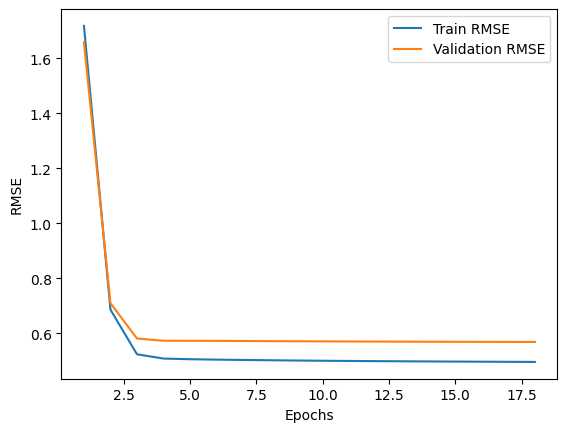

In [8]:
best_model_poly = Pipeline([
    ("prep", preprocessor_poly),
    ("sgd", SGDRegressor(
        penalty="l2",
        alpha=0.001,
        learning_rate= "adaptive",
        eta0=0.001,
        max_iter=1,
        warm_start=True,
        tol=None,
        random_state=42
    ))
])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

n_epochs = 18
train_rmse, val_rmse = [], []

for epoch in range(n_epochs):
    best_model_poly.fit(X_train, y_train)
    y_train_pred = best_model_poly.predict(X_train)
    y_val_pred = best_model_poly.predict(X_val)

    train_rmse.append(root_mean_squared_error(y_train, y_train_pred))
    val_rmse.append(root_mean_squared_error(y_val, y_val_pred))

plt.plot(range(1, n_epochs+1), train_rmse, label="Train RMSE")
plt.plot(range(1, n_epochs+1), val_rmse, label="Validation RMSE")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()
plt.show()

There is neither over or underfitting, this is a good fit because the Validation RMSE levels off slightly above the slowly decreaseing Train RMSE

F) predictions using best model

In [9]:
X_test = test_data.drop("Life Ladder", axis=1)
y_test = test_data["Life Ladder"]

y_test_poly_pred = best_model_poly.predict(X_test)
y_test_pred = best_model.predict(X_test)


test_poly_rmse = root_mean_squared_error(y_test, y_test_poly_pred)
test_rmse = root_mean_squared_error(y_test, y_test_pred)

print(f"Test Poly RMSE: {test_poly_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

Test Poly RMSE: 0.5262
Test RMSE: 0.5557


The polynomial model is the best off the train data. I tried the polyomial with a poly degree of higher than 3, although it had a better RMSE it showed that it overfit when using it on the test data. I believe it is because the model was too complex and doesn't generalize well due to random noise it may pick up as well